In [2]:
import math
import time
import random
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from bessel_zeros import get_bessel_zeros
from scipy.special import jv, jvp, gamma, loggamma
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [3]:
# ── PARAMETERS ──────────────────────────────────────────────────────────────
T_total = 1.0
DIM     = 3
S       = 1.  # cylinder nondimensional step
N_ZEROS = 10
INV_R   = 2000
INV_T   = 2000
K       = 1.1
s       = 1.0
N_PATHS = 200_000
tol     = 1e-8
_eps    = np.finfo(np.float64).eps
nu  = DIM/2.0 - 1.0

$$ \mathbb{P}\left(\frac{\tau_R}{T}\le s\right)\tfrac{1}{2^{\nu-1}\Gamma(\nu+1)}\sum_{n=1}^\infty
\tfrac{(z_{\nu,n})^{\nu-1}}{J_{\nu+1}(z_{\nu,n})}\,
\exp\!\left(-\tfrac{z_{\nu,n}^2S}{2}s\right)$$

$$\log\left(\tfrac{1}{2^{\nu-1}\Gamma(\nu+1)}\tfrac{(z_{\nu,n})^{\nu-1}}{J_{\nu+1}(z_{\nu,n})}\,
\exp\!\left(-\tfrac{z_{\nu,n}^2S}{2}s\right)\right)= -(\nu-1)\log 2 - \log\Gamma(\nu+1) (\nu-1)\log z_{\nu,n}-\log J_{\nu+1}(z_{\nu,n}) -\tfrac{z_{\nu,n}^2S}{2}s $$

In [4]:
print("Computing Bessel function zeros…")
zeros = get_bessel_zeros(DIM, N_ZEROS)
print(f" Retrieved {len(zeros)} zeros for ν={DIM/2 -1}")

Computing Bessel function zeros…
 Retrieved 10 zeros for ν=0.5


Eigenvalues are $\frac{z_{\nu,n}^2}{2}$

In [5]:
x   = np.asarray(zeros, dtype=np.float64)                 # z_{ν,n}
lam = (x*x) / 2.0    # eigenvalues of (1/2)Δ on unit ball = z_{ν,n}^2 / 2


In [6]:
#placeholder for saving cdf of $\rho$ and $\tau$
r_star = np.linspace(0.0, 1.0, int(INV_R), dtype=np.float64)
t_star = np.linspace(0.0, 1.0, int(INV_T), dtype=np.float64)

In the denominator: $J_{\nu+1}(z_{ν,n})=-J'_\nu(z)$ (Claim is more stability.)

In [7]:
# ----- stable J_{ν+1}(z_{ν,n}) at roots via derivative identity -----
# At zeros of J_ν, we have J_{ν+1}(z) = - J'_ν(z) [Watson treatise page 45 (4)]
Jnu1_roots = -jvp(nu, x, 1)  # derivative w.r.t. argument

$ \tfrac{1}{2^{\nu-1}\Gamma(\nu+1)}$

In [8]:
# ----- weights (temporal & spatial) -----
# coef = 1 / (2^{ν-1} Γ(ν+1))
coef = 1.0 / (2.0**(nu - 1.0) * gamma(nu + 1.0))
coef

1.5957691216057306

In [9]:
eps = np.finfo(np.float64).tiny

$$\log\left(\tfrac{1}{2^{\nu-1}\Gamma(\nu+1)}\tfrac{(z_{\nu,n})^{\nu-1}}{|J_{\nu+1}(z_{\nu,n})|}\,
\exp\!\left(-\tfrac{z_{\nu,n}^2S}{2}s\right)\right)= -(\nu-1)\log 2 - \log\Gamma(\nu+1) + (\nu-1)\log z_{\nu,n}-\log |J_{\nu+1}(z_{\nu,n})| -\tfrac{z_{\nu,n}^2S}{2}s $$

In [10]:
# A_den = coef * x^{ν-1} / J_{ν+1}(x)
# Use logs for A_den downstream; still keep a non-log version for shapes/checks if needed
# log A_den = (nu-1)*log x - (nu-1)*log 2 - log Γ(nu+1) - log J_{ν+1}(x)
logA_den = (nu - 1.0) * np.log(np.maximum(x, eps)) \
    - (nu - 1.0) * np.log(2.0) \
    - loggamma(nu + 1.0) \
    - np.log(np.maximum(np.abs(Jnu1_roots), eps))

In [11]:
# Keep the correct sign for A_den (J_{ν+1} may change sign):
sign_A_den = np.sign(Jnu1_roots)
# log with sign: A_den = (coef / J_{ν+1}) * x^{ν-1}; 'coef' part goes into logA_den above implicitly.
# Since coef > 0, sign is just sign of 1/J_{ν+1} = sign(J_{ν+1})
# We'll incorporate sign when summing (below we use pure log-sum-exp on magnitudes, so A_den must be ≥0).

In [12]:
sign_A_den

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [13]:
logA_den_mag = logA_den

In [14]:
# ----- exponentials for full nondimensional step S -----
expS = np.exp(-lam * S)  # e^{- (z^2/2) S }

In [15]:
# ----- survival probability p_surv0 with log-sum-exp -----
# p_surv0 = Σ_n A_den * e^{-lam*S}
# => log terms = logA_den_mag - lam*S
log_terms_surv = logA_den_mag - lam * S
m = np.max(log_terms_surv)
p_surv0 = float(np.exp(m) * np.sum(sign_A_den*np.exp(log_terms_surv - m)))
p_surv0,np.sum(sign_A_den*np.exp(log_terms_surv))

(0.014383761361077075, 0.014383761361077075)

In [16]:
# sign_A_den,np.exp(log_terms_surv)

$$\mathbb{P}(|X_T|\le \rho) = \tfrac{\left(\tfrac{\rho}{R}\right)^{\nu+1}}{2^{\nu-1}\Gamma(\nu+1)}\sum_{n=1}^\infty
\tfrac{(z_{\nu,n})^{\nu-1}}{J_{\nu+1}^2(z_{\nu,n})}\,
J_{\nu+1}\!\left(\tfrac{z_{\nu,n}\rho}{R}\right)\,
\exp\!\left(-\tfrac{z_{\nu,n}^2T}{2R^2}\right)$$

In [17]:
# A_num = 2 / ( x [J_{ν+1}(x)]^2 )
# Use derivative-based J_{ν+1} at roots for stability:
# A_num = 2.0 / (np.maximum(x, eps) * np.maximum(Jnu1_roots*Jnu1_roots, eps))
# Change A_num to the correct form
A_num = np.maximum(x, eps)**(nu-1) / np.maximum(Jnu1_roots*Jnu1_roots, eps)
log_A_num = (nu - 1.0) * np.log(np.maximum(x, eps)) - 2.0 * np.log(np.maximum(np.abs(Jnu1_roots), eps))
# sign_A_num = np.sign(Jnu1_roots) * np.sign(Jnu1_roots)  # square of J_{ν+1} sign
A_num[:,None].shape

(10, 1)

$J_{\nu+1}\!\left(\tfrac{z_{\nu,n}\rho}{R}\right)$

In [18]:
Jp1 = jv(nu + 1.0, np.outer(x, r_star))  # shape (N_roots, INV_R)

In [19]:
x.shape, r_star.shape, np.outer(x, r_star).shape

((10,), (2000,), (10, 2000))

$\rho^{\nu+1}$

In [20]:
rwt = r_star**(nu + 1.0)
rwt.shape

(2000,)

$\dfrac{2}{z_{\nu,n}J_{\nu+1}^2(z_{\nu,n})}\exp\!\left(-\tfrac{z_{\nu,n}^2T}{2R^2}\right)J_{\nu+1}\!\left(\tfrac{z_{\nu,n}\rho}{R}\right)\rho^{\nu+1}$

In [21]:
terms = (A_num[:, None] * expS[:, None]) * Jp1 
terms.shape

(10, 2000)

In [22]:
(coef*A_num[:, None]*expS[:, None]*Jp1).shape, rwt.shape

((10, 2000), (2000,))

In [23]:
# Columnwise scaled summation to avoid overflow/underflow while keeping signs:
scale = np.max(np.abs(terms), axis=0)# max over rows for each column
safe_scale = np.where(scale > 0.0, scale, 1.0)
sum_scaled = np.sum(terms / safe_scale, axis=0, dtype=np.float64)
cdf_num = coef*sum_scaled * safe_scale* rwt
cdf_r = cdf_num/p_surv0

In [30]:
scale.shape,safe_scale.shape,rwt.shape,cdf_num.shape,cdf_r.shape

((2000,), (2000,), (2000,), (2000,), (2000,))

In [28]:
cdf_r.shape

(2000,)

In [26]:
log_terms_time = logA_den_mag[:, None] - (lam[:, None] * (S * t_star[None, :]))
m_t = np.max(log_terms_time, axis=0)
sum_time = np.exp(m_t) * np.sum(sign_A_den[:,None]*np.exp(log_terms_time - m_t[None, :]), axis=0)
raw_t_num = 1.0 - sum_time
raw_t_num = np.minimum.accumulate(raw_t_num[::-1])[::-1]
raw_t = raw_t_num/(1-p_surv0)
raw_t = np.clip(raw_t, 0.0, 1.0)
# raw_t = np.minimum.accumulate(raw_t[::-1])[::-1]

raw_t_num[0]

2.63623530338819e-07

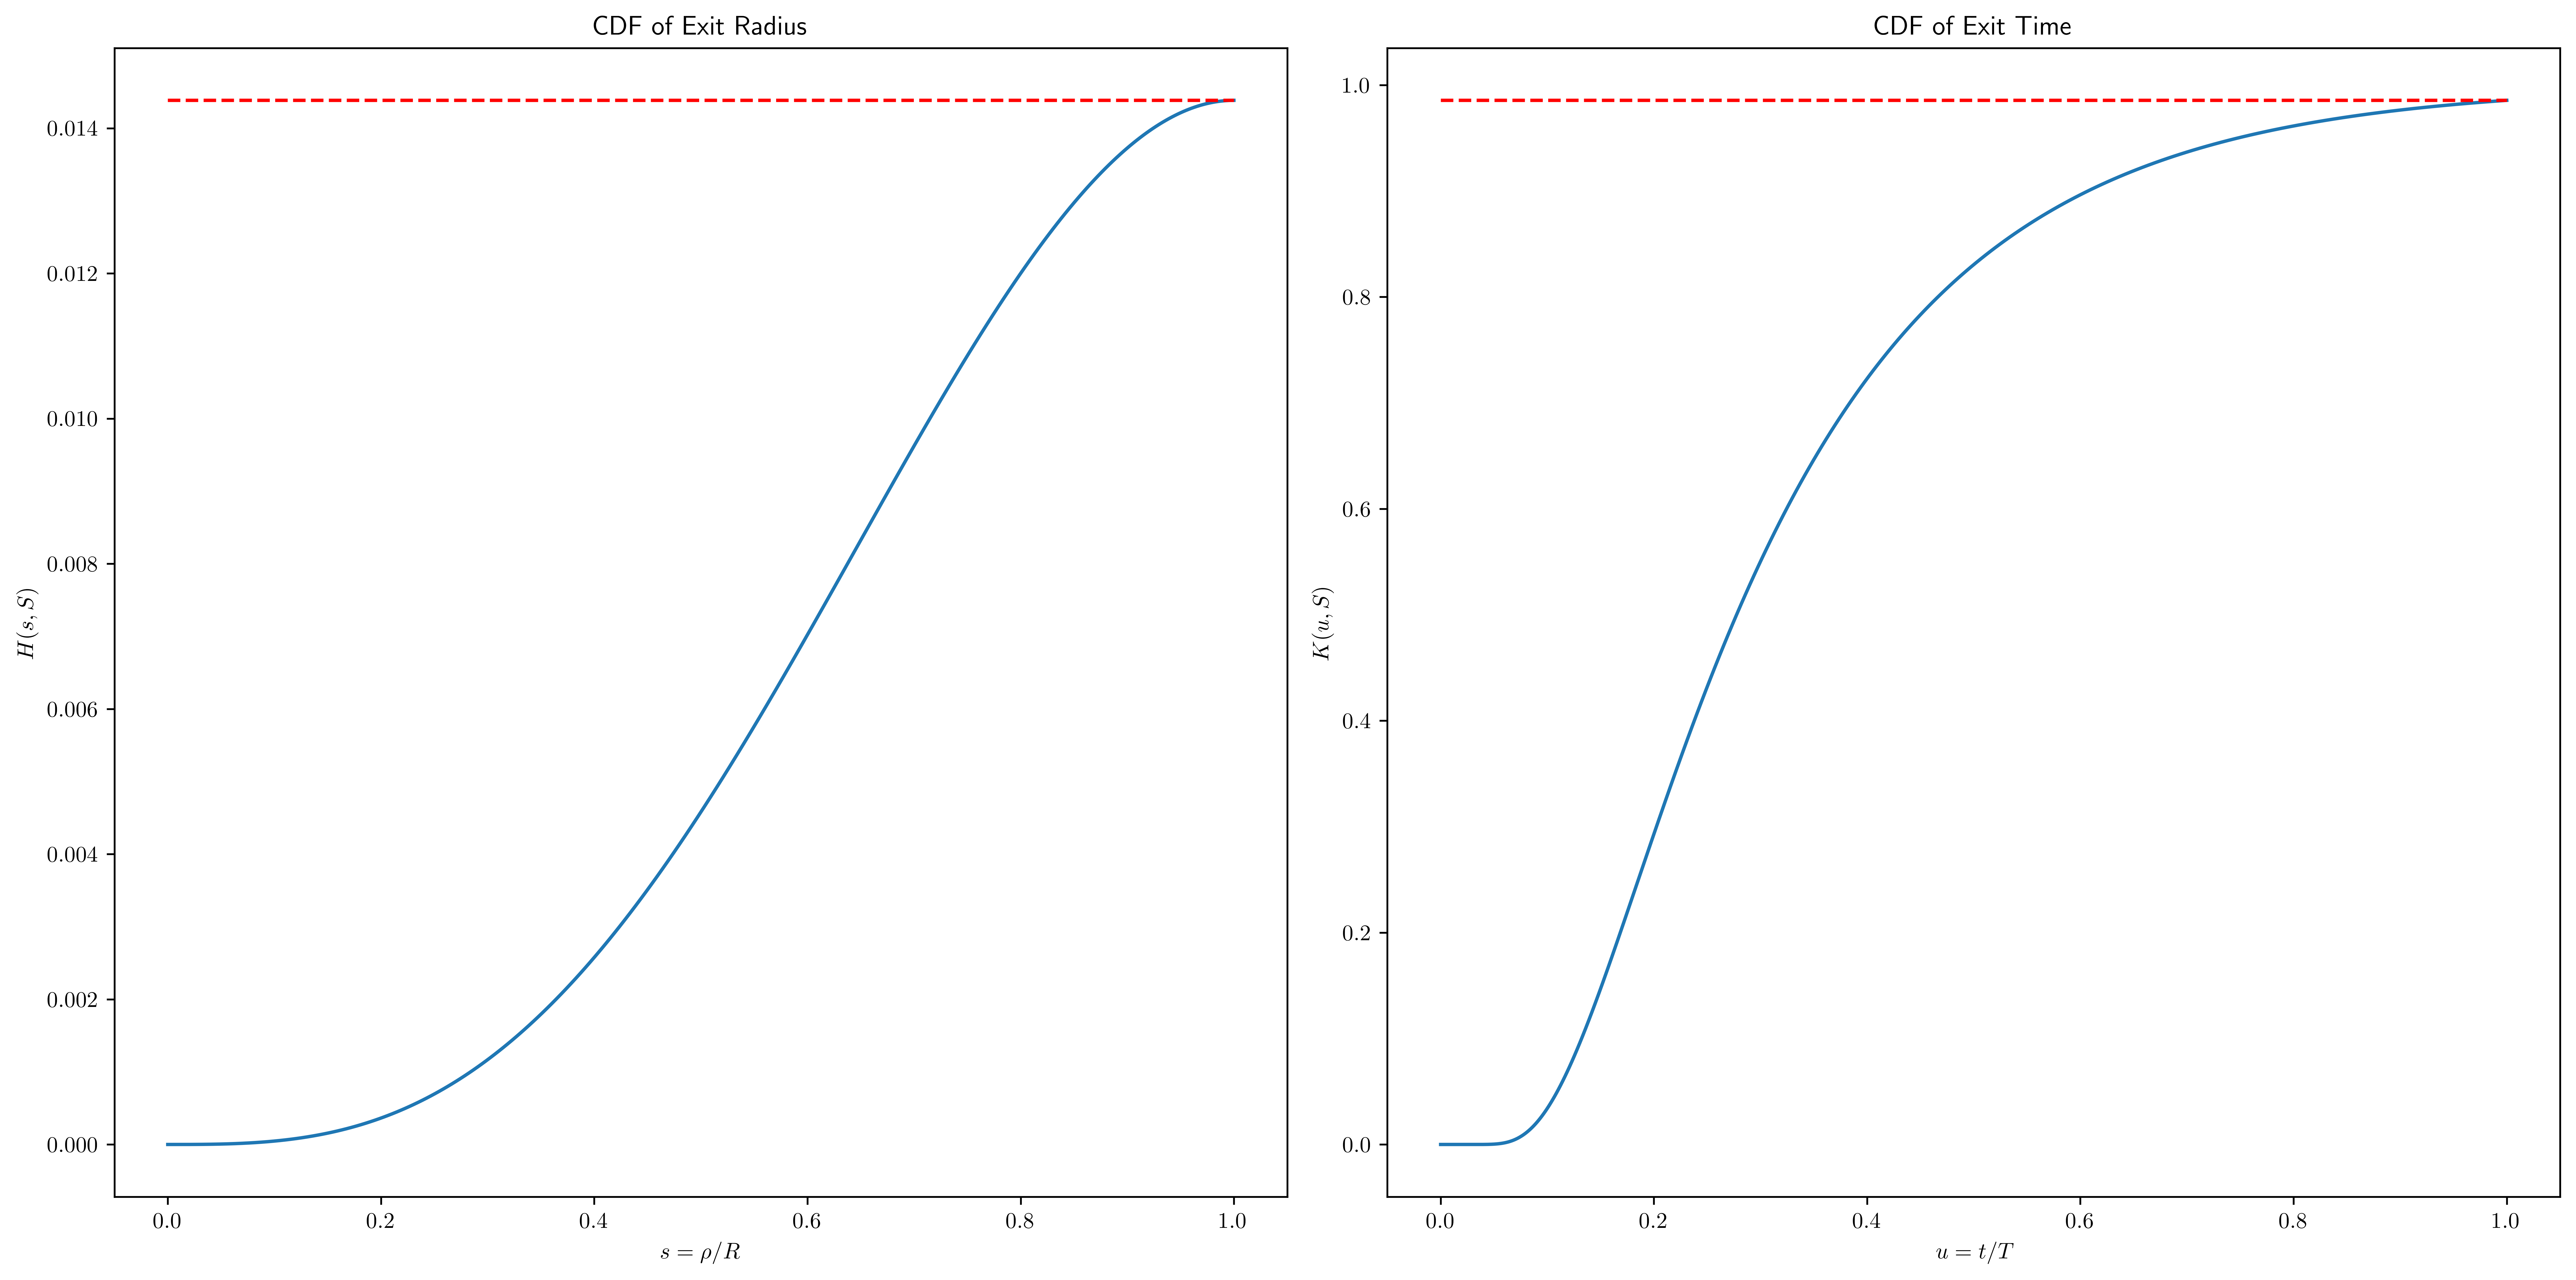

In [27]:
f = plt.figure(figsize=(16, 8),dpi = 600);
ax1 = f.add_subplot(1, 2, 1)
ax1.plot(r_star,cdf_num)
ax1.hlines(p_surv0,0,1,colors='r',linestyles='dashed')
ax1.set_title('CDF of Exit Radius')
ax1.set_xlabel(r'$s=\rho/R$')
ax1.set_ylabel(r'$H(s,S)$');
ax2 = f.add_subplot(1, 2, 2)
# ind = np.where(raw_t>.9999999999)[0][0]
ax2.plot(t_star,raw_t_num)
ax2.hlines(1-p_surv0,0,1,colors='r',linestyles='dashed')
ax2.set_title('CDF of Exit Time')
ax2.set_xlabel(r'$u=t/T$')
ax2.set_ylabel(r'$K(u,S)$');
plt.tight_layout()
plt.savefig('CDFs.png',bbox_inches='tight')